# U-Net Training with PyTorch (Modular Design)

This notebook implements a modular approach to training a U-Net model for cell segmentation. It includes:

1. Module definitions and imports
2. Image and mask selection module (10 images)
3. Patch generation and database storage module
4. DataLoader module for efficient training
5. Training module with U-Net model
6. Testing module with visualization

In [13]:
# Generated by Copilot
# Core imports
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import random
import logging

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm


# Add project root to path
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# Import project modules
from app.services.ai.models import UNet
from app.services.image.patch_service import (
    split2patches,
    load_patches,
)
from app.db.models import Image, Cell, Mask, Base
from app.db.session import SessionLocal

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set random seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set paths
data_path = Path(project_root, "data")
image_path = data_path / "dataset" / "images"
mask_path = data_path / "dataset" / "masks"
model_path = data_path / "models"


PyTorch version: 2.2.0+cu121
Using device: cuda
GPU: NVIDIA GeForce MX150


## 1. Data Loading

Load image and mask data from the database. We'll use the `SessionLocal` to query the database and retrieve images and masks that are ready for training.

In [30]:
# Generated by Copilot
from typing import List, Tuple, TypedDict

class ImageWithMasks(TypedDict):
    image: np.ndarray
    masks: np.ndarray
    cell_id: int
    is_done: bool

def load_dataset_from_db() -> Tuple[List[ImageWithMasks], List[Cell]]:
    """Load dataset information from database and filter for non-empty masks"""
    session = SessionLocal()
    valid_masks: List[ImageWithMasks] = []
    try:
        # Get all images and cells
        images = session.query(Image).all()
        cells = session.query(Cell).all()

        # Dictionary to store images with non-empty masks

        for image in images[:10]:  # Limit to first 10 images for testing
            # Get all masks for this image
            masks = session.query(Mask).filter(Mask.image_id == image.id).all()


            for mask in masks:
                # Check if mask file exists
                mask.mask_path = "../" + mask.mask_path  # Adjust path if needed
                if not os.path.exists(mask.mask_path):
                    print(f"Mask file does not exist: {mask.mask_path}")
                    continue

                # Load mask and check if it's not all zeros
                try:
                    mask_array = np.load(mask.mask_path)
                    if mask_array is not None and np.any(mask_array > 0):
                        image_array = cv2.imread("../"+image.img_path, cv2.IMREAD_GRAYSCALE)
                        if image_array is None:
                            print(f"Image file does not exist: {image.img_path}")
                            continue 
                        valid_masks.append(ImageWithMasks(image=image_array, masks=mask_array, cell_id=mask.cell_id, is_done=False))
                except Exception as e:
                    print(f"Error loading mask {mask.mask_path}: {e}")

        return valid_masks, cells
    finally:
        session.close()


# Load the dataset
images_with_masks, cells = load_dataset_from_db()
print(f"Found {len(images_with_masks)} images with non-empty masks")
print(f"Found {len(cells)} cell types")


Found 12 images with non-empty masks
Found 2 cell types


## 2. Generate Patches

Split images and masks into patches for training. We'll use the `patch_service` module to create and save patches.

Converted 95 patches from 12 images with masks


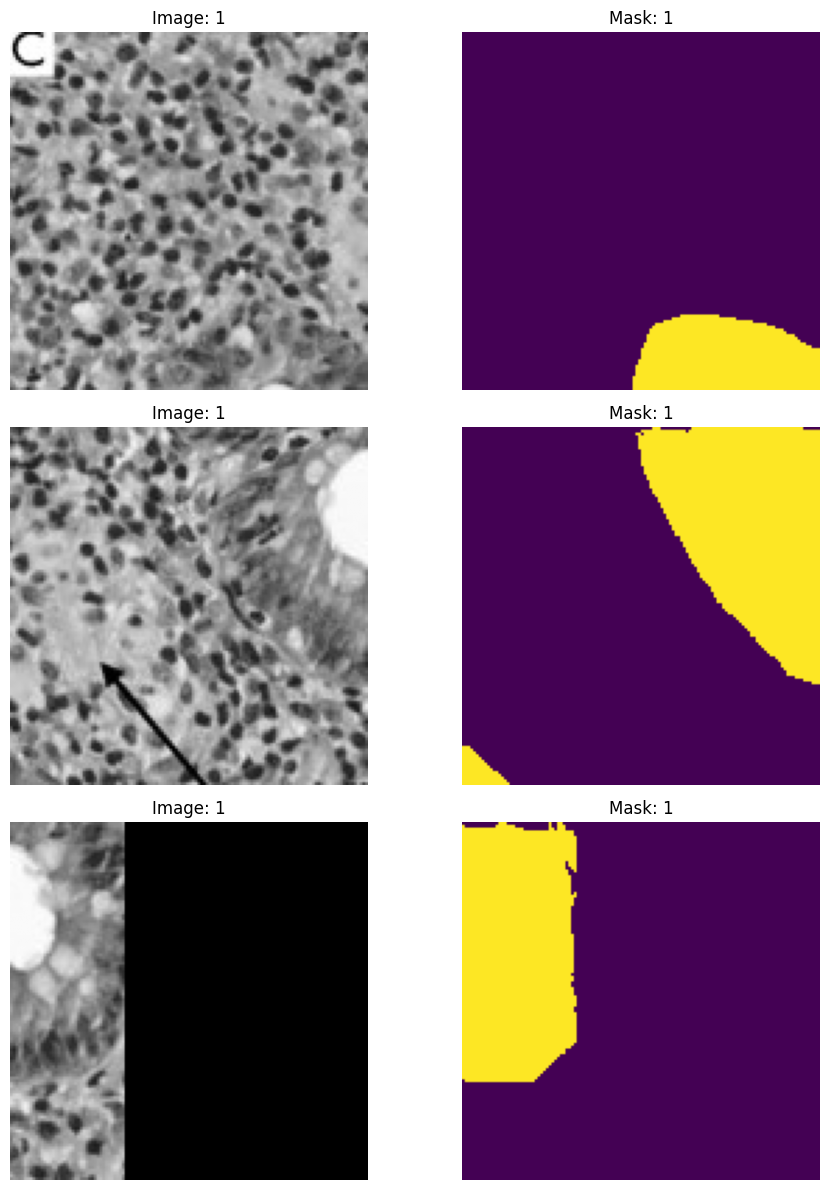

In [35]:

class PatchData(TypedDict):
    """Data model for patch information"""
    img_patch: np.ndarray
    mask_patch: np.ndarray
    cell_id: int
    is_done: bool   


def convert2patches(images_with_masks: List[ImageWithMasks]) -> List[PatchData]:
    patches: List[PatchData] = []
    for image_with_mask in images_with_masks:
        img = image_with_mask["image"]
        mask = image_with_mask["masks"]
        img_patches, mask_patches = split2patches(img, ), split2patches(mask)
        for (img_patch,_), (mask_patch,_) in zip(img_patches, mask_patches):
            patches.append(PatchData(img_patch=img_patch, mask_patch=mask_patch, cell_id=image_with_mask["cell_id"], is_done=False))
    return patches

# Visualize some patches
def visualize_patches(patches: List[PatchData], n_samples=3):
    """Visualize a few sample patches for inspection"""
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 4 * n_samples))
    if n_samples == 1:
        axes = [axes]  # Make sure axes is a list for single sample

    for i, patch_info in enumerate(patches[:n_samples]):
        img_patch = patch_info["img_patch"]
        mask_patch = patch_info["mask_patch"]

        axes[i][0].imshow(img_patch, cmap="gray")
        axes[i][0].set_title(f"Image: {patch_info['cell_id']}")
        axes[i][0].axis("off")

        axes[i][1].imshow(mask_patch, cmap="viridis")
        axes[i][1].set_title(f"Mask: {patch_info['cell_id']}")
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()


# Convert images with masks to patches
patches = convert2patches(images_with_masks)

print(f"Converted {len(patches)} patches from {len(images_with_masks)} images with masks")

# Visualize a few sample patches
if len(patches) > 0:
    visualize_patches(patches[30:], n_samples=3)

## 3. Create Dataset and DataLoader

Create a PyTorch Dataset class to load the patches and a DataLoader for batch training.

Training batches: 5
Validation batches: 2
Batch shape - Images: torch.Size([16, 1, 128, 128]), Masks: torch.Size([16, 1, 128, 128])
Value ranges - Images: [0.00, 1.00], Masks: [0.00, 1.00]


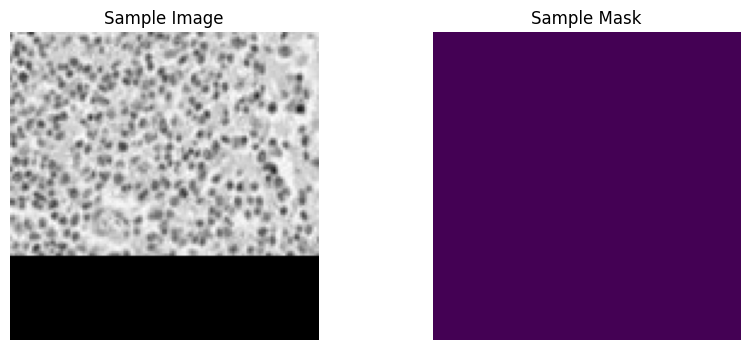

In [37]:

class PatchDataset(Dataset):
    """Dataset for patch-based segmentation using database"""

    def __init__(self, patches: List[PatchData], transform=None):
        self.patches = patches

        if transform is None:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust normalization as needed
            ])
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch_info = self.patches[idx]
        # Access dictionary items using string keys
        img_tensor = torch.from_numpy(patch_info["img_patch"]).float()
        mask_tensor = torch.from_numpy(patch_info["mask_patch"]).float()
        
        # Normalize image to [0,1] range
        img_tensor = img_tensor / 255.0
        
        # Convert to tensors with correct shape
        img_tensor = img_tensor.unsqueeze(0)  # Add channel dimension
        mask_tensor = mask_tensor.unsqueeze(0)  # Add channel dimension
        
        return img_tensor, mask_tensor



# Split patches into training and validation sets
train_size = int(0.8 * len(patches))
# Create dataloaders
batch_size = 16
train_dataset = PatchDataset(patches[:train_size])
val_dataset = PatchDataset(patches[train_size:])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Check a batch
if len(train_loader) > 0:
    sample_batch = next(iter(train_loader))
    images, masks = sample_batch
    print(f"Batch shape - Images: {images.shape}, Masks: {masks.shape}")
    print(
        f"Value ranges - Images: [{images.min():.2f}, {images.max():.2f}], Masks: [{masks.min():.2f}, {masks.max():.2f}]"
    )

    # Visualize a sample
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(images[0, 0].numpy(), cmap="gray")
    axes[0].set_title("Sample Image")
    axes[0].axis("off")

    axes[1].imshow(masks[0, 0].numpy(), cmap="viridis")
    axes[1].set_title("Sample Mask")
    axes[1].axis("off")

    plt.show()

In [38]:
class PatchDataset(Dataset):
    """Dataset for patch-based segmentation using database"""

    def __init__(self, patches: List[PatchData], transform=None):
        self.patches = patches

        if transform is None:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust normalization as needed
            ])
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch_info = self.patches[idx]
        # Access dictionary items using string keys
        img_tensor = torch.from_numpy(patch_info["img_patch"]).float()
        mask_tensor = torch.from_numpy(patch_info["mask_patch"]).float()
        
        # Normalize image to [0,1] range
        img_tensor = img_tensor / 255.0
        
        # Convert to tensors with correct shape
        img_tensor = img_tensor.unsqueeze(0)  # Add channel dimension
        mask_tensor = mask_tensor.unsqueeze(0)  # Add channel dimension
        
        return img_tensor, mask_tensor

## 4. Define Loss Functions and Training Utilities

Implement the dice loss and other training utilities for the U-Net model.

In [39]:
# Generated by Copilot
# Define loss functions
def dice_coef(pred, target, smooth=1.0):
    """Calculate Dice coefficient"""
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()

    return (2.0 * intersection + smooth) / (
        pred_flat.sum() + target_flat.sum() + smooth
    )


def dice_loss(pred, target, smooth=1.0):
    """Dice loss function"""
    return 1 - dice_coef(pred, target, smooth)


def combined_loss(pred, target):
    """Combined BCE and Dice loss"""
    bce = nn.BCEWithLogitsLoss()(pred, target)
    pred_sigmoid = torch.sigmoid(pred)
    dice = dice_loss(pred_sigmoid, target)
    return 0.5 * bce + 0.5 * dice


# Evaluation metrics
def calculate_metrics(pred, target, threshold=0.5):
    """Calculate metrics for evaluation"""
    # Apply sigmoid and threshold
    pred_sigmoid = torch.sigmoid(pred)
    pred_binary = (pred_sigmoid > threshold).float()

    # Move to CPU for numpy operations
    pred_binary = pred_binary.cpu().detach()
    target = target.cpu().detach()

    # Calculate accuracy
    accuracy = (pred_binary == target).float().mean().item()

    # Calculate Dice coefficient
    dice = dice_coef(pred_binary, target).item()

    # Calculate IoU (Intersection over Union)
    intersection = (pred_binary * target).sum().item()
    union = pred_binary.sum().item() + target.sum().item() - intersection
    iou = intersection / union if union > 0 else 0.0

    return {"accuracy": accuracy, "dice": dice, "iou": iou}


# Training and validation functions
def train_epoch(model, dataloader, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0

    for batch_idx, (images, masks) in enumerate(tqdm(dataloader, desc="Training")):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = combined_loss(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()

    return running_loss / len(dataloader)


def validate(model, dataloader, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    metrics = {"accuracy": 0.0, "dice": 0.0, "iou": 0.0}

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = combined_loss(outputs, masks)

            # Update statistics
            running_loss += loss.item()

            # Calculate metrics
            batch_metrics = calculate_metrics(outputs, masks)
            for key in metrics:
                metrics[key] += batch_metrics[key]

    # Average metrics
    for key in metrics:
        metrics[key] /= len(dataloader)

    return running_loss / len(dataloader), metrics

## 5. Set Up the U-Net Model

Initialize the U-Net model using the class defined in your AI service modules.

In [40]:
# Generated by Copilot
# Initialize the U-Net model
model = UNet(n_channels=1, n_classes=1, bilinear=True)
model = model.to(device)

# Check if a previously trained model exists
model_file = model_path / "unet_pytorch.pth"
if model_file.exists():
    try:
        model.load_state_dict(torch.load(model_file, map_location=device))
        print(f"Loaded existing model from {model_file}")
    except Exception as e:
        print(f"Error loading model: {e}")


# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model parameters: {count_parameters(model):,}")

# Set up optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, verbose=True
)

# Display model architecture
print(model)

Model parameters: 17,261,825
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

/mnt/d/Vault/Coding/02_Projects/AI_Dev/CrohnScope/backend/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## 6. Train the Model

Train the U-Net model using the prepared data and track the training progress.


Epoch 1/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6219, Val Loss: 0.7240
Val Metrics - Accuracy: 0.8019, Dice: 0.5000, IoU: 0.0000
Saved best model with validation loss: 0.7240

Epoch 2/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6062, Val Loss: 0.8529
Val Metrics - Accuracy: 0.7867, Dice: 0.0009, IoU: 0.0002

Epoch 3/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5790, Val Loss: 0.7273
Val Metrics - Accuracy: 0.7953, Dice: 0.0928, IoU: 0.0495

Epoch 4/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5494, Val Loss: 0.7698
Val Metrics - Accuracy: 0.8009, Dice: 0.5374, IoU: 0.0194

Epoch 5/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5648, Val Loss: 1.0907
Val Metrics - Accuracy: 0.8010, Dice: 0.0500, IoU: 0.0000

Epoch 6/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5383, Val Loss: 0.5311
Val Metrics - Accuracy: 0.8699, Dice: 0.3983, IoU: 0.3020
Saved best model with validation loss: 0.5311

Epoch 7/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5084, Val Loss: 0.4459
Val Metrics - Accuracy: 0.9135, Dice: 0.9057, IoU: 0.3413
Saved best model with validation loss: 0.4459

Epoch 8/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5057, Val Loss: 0.4800
Val Metrics - Accuracy: 0.9081, Dice: 0.8837, IoU: 0.3113

Epoch 9/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4850, Val Loss: 0.4716
Val Metrics - Accuracy: 0.8715, Dice: 0.8774, IoU: 0.3031

Epoch 10/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5277, Val Loss: 0.6752
Val Metrics - Accuracy: 0.8017, Dice: 0.5003, IoU: 0.0001

Epoch 11/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5004, Val Loss: 0.7133
Val Metrics - Accuracy: 0.8022, Dice: 0.5169, IoU: 0.0086

Epoch 12/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5124, Val Loss: 0.4741
Val Metrics - Accuracy: 0.9003, Dice: 0.8692, IoU: 0.2926

Epoch 13/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4889, Val Loss: 0.4552
Val Metrics - Accuracy: 0.9111, Dice: 0.8985, IoU: 0.3312

Epoch 14/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4757, Val Loss: 0.5886
Val Metrics - Accuracy: 0.8540, Dice: 0.7275, IoU: 0.1473

Epoch 15/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4885, Val Loss: 0.6637
Val Metrics - Accuracy: 0.8201, Dice: 0.6129, IoU: 0.0636

Epoch 16/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4467, Val Loss: 0.6901
Val Metrics - Accuracy: 0.8157, Dice: 0.5954, IoU: 0.0527

Epoch 17/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4415, Val Loss: 0.7933
Val Metrics - Accuracy: 0.8027, Dice: 0.5079, IoU: 0.0040
Early stopping at epoch 17. No improvement for 10 epochs.


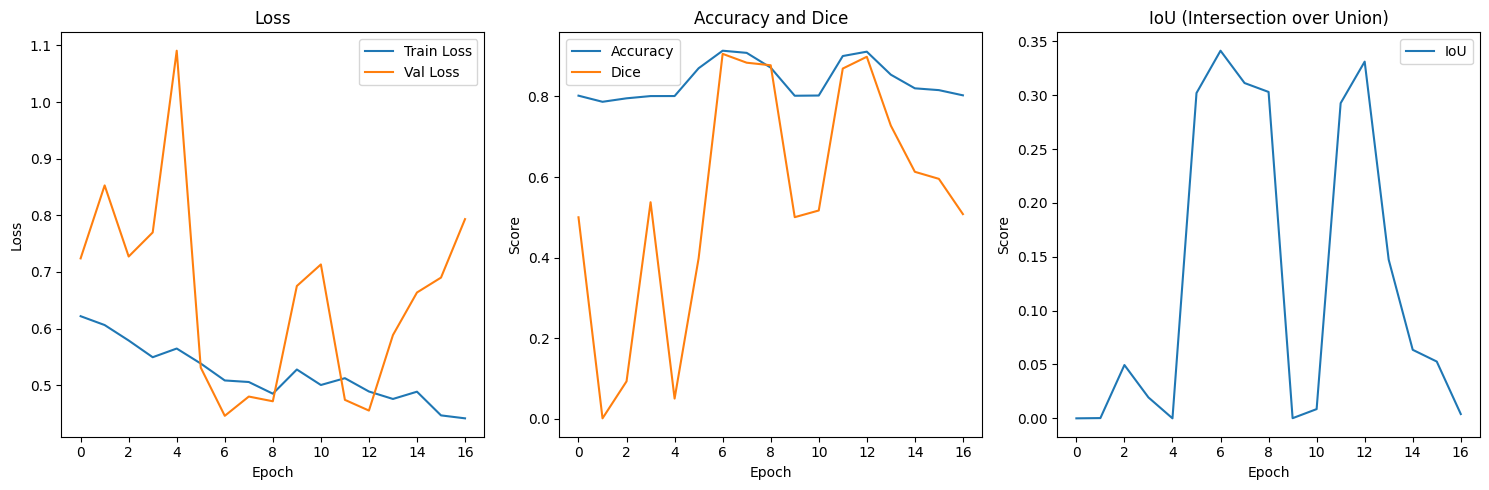

In [41]:
# Generated by Copilot
# Training parameters
num_epochs = 50
early_stopping_patience = 10

# Training history
history = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": [],
    "val_dice": [],
    "val_iou": [],
}

# Early stopping variables
best_val_loss = float("inf")
no_improve_epoch = 0

# Train the model
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, device)

    # Validate
    val_loss, val_metrics = validate(model, val_loader, device)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(
        f"Val Metrics - Accuracy: {val_metrics['accuracy']:.4f}, Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}"
    )

    # Update history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_metrics["accuracy"])
    history["val_dice"].append(val_metrics["dice"])
    history["val_iou"].append(val_metrics["iou"])

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(model.state_dict(), str(model_path / "unet_pytorch_best.pth"))
        print(f"Saved best model with validation loss: {val_loss:.4f}")
        no_improve_epoch = 0
    else:
        no_improve_epoch += 1

    # Save the current model state
    torch.save(model.state_dict(), str(model_path / "unet_pytorch.pth"))

    # Early stopping
    if no_improve_epoch >= early_stopping_patience:
        print(
            f"Early stopping at epoch {epoch}. No improvement for {early_stopping_patience} epochs."
        )
        break

    # If dice is very high, we can also stop
    if val_metrics["dice"] > 0.95:
        print(
            f"Stopping at epoch {epoch}. Achieved very high Dice score: {val_metrics['dice']:.4f}"
        )
        break

# Plot training history
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(history["val_accuracy"], label="Accuracy")
plt.plot(history["val_dice"], label="Dice")
plt.title("Accuracy and Dice")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

# Plot IoU
plt.subplot(1, 3, 3)
plt.plot(history["val_iou"], label="IoU")
plt.title("IoU (Intersection over Union)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()

## 7. Evaluate the Model

Evaluate the trained model on the validation set and visualize the results.

In [ ]:
# Generated by Copilot
# Load the best model
best_model_path = model_path / "unet_pytorch_best.pth"
if best_model_path.exists():
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Loaded best model from {best_model_path}")

# Set model to evaluation mode
model.eval()


# Function to visualize predictions
def visualize_predictions(model, dataloader, num_samples=5):
    """Visualize model predictions on samples from the dataloader"""
    model.eval()

    # Get a batch of data
    dataiter = iter(dataloader)
    images, masks = next(dataiter)

    # Make predictions
    with torch.no_grad():
        images_device = images.to(device)
        outputs = model(images_device)
        preds = torch.sigmoid(outputs) > 0.5

    # Move tensors to CPU for plotting
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Plot images, masks, and predictions
    n = min(num_samples, len(images))
    plt.figure(figsize=(15, 5 * n))

    for i in range(n):
        # Original image
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(images[i, 0], cmap="gray")
        plt.title(f"Image {i+1}")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(masks[i, 0], cmap="viridis")
        plt.title(f"Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(preds[i, 0], cmap="viridis")
        plt.title(f"Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Visualize predictions on validation set
if len(val_loader) > 0:
    visualize_predictions(model, val_loader, num_samples=5)

## 8. Test on New Images

Test the model on new images that weren't part of the training or validation sets.

In [ ]:
# Generated by Copilot
# Get a list of all images and exclude those we've already used
def get_unused_images(used_images):
    """Get images that weren't used in training or validation"""
    all_image_files = list(image_path.glob("*.jpg")) + list(image_path.glob("*.png"))

    # Get used image filenames
    used_filenames = set()
    for image_data in used_images.values():
        used_filenames.add(os.path.basename(image_data["image_path"]))

    # Filter unused images
    unused_images = []
    for img_file in all_image_files:
        if img_file.name not in used_filenames:
            unused_images.append(img_file)

    return unused_images


# Get unused images
unused_images = get_unused_images({**train_images, **val_images})
print(f"Found {len(unused_images)} unused images")

# Select a few images for testing
test_images = random.sample(unused_images, min(5, len(unused_images)))


# Function to process a full image through the model
def process_full_image(img_path, model, patch_size=128):
    """Process a full image by splitting it into patches, predicting masks, and reconstructing"""
    # Load the image
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None, None

    # Get original dimensions
    orig_h, orig_w = img.shape

    # Split into patches
    patches_with_pos = split2patches(img, patch_size)

    # Create empty full-size mask
    # Calculate padded dimensions
    pad_h = (patch_size - orig_h % patch_size) % patch_size
    pad_w = (patch_size - orig_w % patch_size) % patch_size
    padded_h, padded_w = orig_h + pad_h, orig_w + pad_w

    # Initialize full mask array
    full_mask = np.zeros((padded_h, padded_w))

    # Process each patch
    model.eval()
    with torch.no_grad():
        for patch, (x, y) in patches_with_pos:
            # Normalize and convert to tensor
            patch_norm = patch.astype(np.float32) / 255.0
            patch_tensor = (
                torch.from_numpy(patch_norm).unsqueeze(0).unsqueeze(0).to(device)
            )

            # Predict mask
            output = model(patch_tensor)
            pred_mask = torch.sigmoid(output) > 0.5

            # Add prediction to the full mask
            full_mask[y : y + patch_size, x : x + patch_size] = (
                pred_mask.squeeze().cpu().numpy()
            )

    # Crop back to original size
    full_mask = full_mask[:orig_h, :orig_w]

    return img, full_mask


# Process and visualize test images
for img_path in test_images:
    img, pred_mask = process_full_image(img_path, model)
    if img is None:
        continue

    # Try to find a matching mask for this image if it exists
    mask_path = mask_path / f"{img_path.stem}.png"
    if mask_path.exists():
        true_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        true_mask = (true_mask > 0).astype(np.float32)

        # Calculate metrics
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()
        iou = intersection / union if union > 0 else 0

        # Count cells (connected components)
        from scipy import ndimage

        _, num_true_cells = ndimage.label(true_mask)
        _, num_pred_cells = ndimage.label(pred_mask)

        # Visualize with true mask
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Image: {img_path.name}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap="viridis")
        plt.title(f"True Mask: {num_true_cells} cells")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap="viridis")
        plt.title(f"Predicted Mask: {num_pred_cells} cells, IoU: {iou:.4f}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        print(f"Image: {img_path.name}")
        print(f"IoU: {iou:.4f}")
        print(f"True cells: {num_true_cells}, Predicted cells: {num_pred_cells}")
    else:
        # Just visualize the prediction
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Image: {img_path.name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask, cmap="viridis")

        # Count cells (connected components)
        from scipy import ndimage

        _, num_cells = ndimage.label(pred_mask)
        plt.title(f"Predicted Mask: {num_cells} cells")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        print(f"Image: {img_path.name}")
        print(f"Predicted cells: {num_cells}")

## 9. Export the Model for Production

Export the trained model in various formats for use in the production environment.

In [ ]:
# Generated by Copilot
# Make sure we're using the best model
if best_model_path.exists():
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Loaded best model for export")

# Save the model in different formats

# 1. Save as PyTorch model
torch.save(model.state_dict(), str(model_path / "unet_final.pth"))
print(f"Saved PyTorch model to {model_path / 'unet_final.pth'}")

# 2. Save as TorchScript model (for production)
model.eval()
scripted_model = torch.jit.script(model)
torch.jit.save(scripted_model, str(model_path / "unet_scripted.pt"))
print(f"Saved TorchScript model to {model_path / 'unet_scripted.pt'}")

# 3. Save a sample input for testing
sample_input = torch.randn(1, 1, 128, 128).to(device)
with torch.no_grad():
    traced_model = torch.jit.trace(model, sample_input)
torch.jit.save(traced_model, str(model_path / "unet_traced.pt"))
print(f"Saved traced model to {model_path / 'unet_traced.pt'}")

# 4. Create a helper module to use the model in the application
def create_prediction_module():
    """Create a Python module with functions for using the trained model in production"""
    module_path = project_root / "app" / "services" / "ai" / "unet_predictor.py"

    code = """
# Generated by Copilot
"""Module for making predictions with the trained U-Net model."""

import os
import torch
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Union
import cv2

# Import U-Net model
from app.services.ai.models import UNet
from app.services.image.patch_service import split2patches


class UNetPredictor:
    """Class for making predictions with the trained U-Net model."""

    def __init__(self, model_path: str = None, device: str = None, patch_size: int = 128):
        """Initialize the predictor with a trained model.

        Args:
            model_path: Path to the saved model (if None, uses default path)
            device: Device to use for inference ('cuda' or 'cpu')
            patch_size: Size of patches to use for prediction
        """
        # Set device
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)

        # Set default model path if not provided
        if model_path is None:
            root_dir = Path(__file__).parent.parent.parent.parent
            model_path = str(root_dir / "data" / "models" / "unet_final.pth")

        # Initialize model
        self.model = UNet(n_channels=1, n_classes=1, bilinear=True)

        # Load model weights
        try:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            print(f"Loaded model from {model_path}")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        # Set model to evaluation mode and move to device
        self.model.eval()
        self.model = self.model.to(self.device)

        self.patch_size = patch_size

    def predict_mask(self, image: np.ndarray) -> np.ndarray:
        """Predict mask for an input image.

        Args:
            image: Input image as numpy array (grayscale)

        Returns:
            Predicted mask as numpy array
        """
        # Ensure image is grayscale
        if len(image.shape) > 2 and image.shape[2] > 1:
            # Convert to grayscale if RGB
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Get original dimensions
        orig_h, orig_w = image.shape

        # Split into patches
        patches_with_pos = split2patches(image, self.patch_size)

        # Calculate padded dimensions
        pad_h = (self.patch_size - orig_h % self.patch_size) % self.patch_size
        pad_w = (self.patch_size - orig_w % self.patch_size) % self.patch_size
        padded_h, padded_w = orig_h + pad_h, orig_w + pad_w

        # Initialize full mask array
        full_mask = np.zeros((padded_h, padded_w))

        # Process each patch
        with torch.no_grad():
            for patch, (x, y) in patches_with_pos:
                # Normalize and convert to tensor
                patch_norm = patch.astype(np.float32) / 255.0
                patch_tensor = torch.from_numpy(patch_norm).unsqueeze(0).unsqueeze(0).to(self.device)

                # Predict mask
                output = self.model(patch_tensor)
                pred_mask = torch.sigmoid(output) > 0.5

                # Add prediction to the full mask
                full_mask[y:y+self.patch_size, x:x+self.patch_size] = pred_mask.squeeze().cpu().numpy()

        # Crop back to original size
        full_mask = full_mask[:orig_h, :orig_w]

        return full_mask

    def count_cells(self, mask: np.ndarray) -> int:
        """Count the number of cells in a predicted mask.

        Args:
            mask: Predicted mask as numpy array

        Returns:
            Number of cells (connected components)
        """
        from scipy import ndimage

        # Ensure mask is binary
        binary_mask = (mask > 0.5).astype(np.uint8)

        # Label connected components
        labeled_mask, num_cells = ndimage.label(binary_mask)

        return num_cells, labeled_mask


# Helper function to create a predictor
def load_unet_predictor(model_path: str = None, device: str = None, patch_size: int = 128) -> UNetPredictor:
    """Load a U-Net predictor with the trained model.

    Args:
        model_path: Path to the saved model (default: None, will use the default path)
        device: Device to use for inference ('cuda' or 'cpu')
        patch_size: Size of patches to use for prediction

    Returns:
        UNetPredictor instance
    """
    return UNetPredictor(model_path, device, patch_size)
"""

    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(module_path), exist_ok=True)

    # Write the module
    with open(module_path, 'w') as f:
        f.write(code)

    return module_path

# Create the prediction module
predictor_module_path = create_prediction_module()
print(f"Created prediction module at: {predictor_module_path}")

print("\nModel export complete! The model can now be used in the production application.")

## 10. Using the Model in the Application

Example code for integrating the model into the CrohnScope application.

In [ ]:
# Generated by Copilot
# Example code for using the U-Net model in the application

"""
This is example code that would be used in your FastAPI endpoints:

```python
from app.services.ai.unet_predictor import load_unet_predictor
import cv2
import numpy as np
from fastapi import Depends, HTTPException
from app.db.session import get_db
from sqlalchemy.orm import Session
from app.db.models import Image, Cell, Mask

# Create a predictor at application startup
predictor = load_unet_predictor()

@app.post("/api/analyze-image")
async def analyze_image(image_id: int, db: Session = Depends(get_db)):
    # Get image from database
    image_record = db.query(Image).filter(Image.id == image_id).first()
    if not image_record:
        raise HTTPException(status_code=404, detail="Image not found")

    # Load the image
    image = cv2.imread(image_record.img_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise HTTPException(status_code=500, detail="Failed to load image")

    # Predict mask
    mask = predictor.predict_mask(image)

    # Count cells
    cell_count, labeled_mask = predictor.count_cells(mask)

    # Save the predicted mask
    output_path = f"{image_record.img_path.rsplit(".", 1)[0]}_pred_mask.png"
    cv2.imwrite(output_path, (mask * 255).astype(np.uint8))

    # Create mask record in database
    new_mask = Mask(
        image_id=image_id,
        cell_id=1,  # Set appropriate cell type ID
        mask_path=output_path,
        is_auto_generated=1,
        is_mask_done=0  # Set to 0 so it can be reviewed by human
    )
    db.add(new_mask)
    db.commit()

    return {
        "image_id": image_id,
        "cell_count": cell_count,
        "mask_path": output_path
    }
```
"""

## 2. Image and Mask Selection Module

This module selects 10 images and their masks for training, focusing on those with completed masks.

In [ ]:
# Generated by Copilot
class ImageMaskSelector:
    """
    Module for selecting images and masks for training.
    """

    def __init__(self, num_images=10):
        self.session = SessionLocal()
        self.num_images = num_images

    def __del__(self):
        self.session.close()

    def get_images_with_completed_masks(self):
        """
        Get images that have at least one completed mask.

        Returns:
            Dictionary mapping image_id to image data with associated masks
        """
        images_with_masks = {}

        # Get all images
        images = self.session.query(Image).all()
        cells = self.session.query(Cell).all()

        for image in images:
            # Get all masks for this image
            masks = self.session.query(Mask).filter(Mask.image_id == image.id).all()

            # Skip images without masks
            if not masks:
                continue

            # Check if any mask is marked as done
            completed_masks = [mask for mask in masks if mask.is_mask_done == 1]

            if completed_masks:
                valid_masks = []
                for mask in completed_masks:
                    cell_name = next(
                        (c.name for c in cells if c.id == mask.cell_id), "unknown"
                    )
                    valid_masks.append(
                        {
                            "id": mask.id,
                            "path": mask.mask_path,
                            "cell_id": mask.cell_id,
                            "cell_name": cell_name,
                            "is_annotation_done": mask.is_annotation_done,
                        }
                    )

                images_with_masks[image.id] = {
                    "id": image.id,
                    "path": image.img_path,
                    "filename": image.filename,
                    "diagnosis": image.diagnosis,
                    "masks": valid_masks,
                }

        return images_with_masks

    def select_training_images(self):
        """
        Select a subset of images for training.

        Returns:
            List of dictionaries containing image and mask information
        """
        images_with_masks = self.get_images_with_completed_masks()

        # If we have fewer images than requested, use all of them
        if len(images_with_masks) <= self.num_images:
            selected_images = list(images_with_masks.values())
        else:
            # Select random images
            image_ids = list(images_with_masks.keys())
            selected_ids = random.sample(image_ids, self.num_images)
            selected_images = [images_with_masks[img_id] for img_id in selected_ids]

        logger.info(f"Selected {len(selected_images)} images for training")
        return selected_images


# Create the image selector and get training images
selector = ImageMaskSelector(num_images=10)
training_images = selector.select_training_images()

# Display selected images
for i, img_data in enumerate(training_images):
    print(f"Image {i+1}: {img_data['filename']}")
    for mask in img_data["masks"]:
        print(f"  - Mask: {os.path.basename(mask['path'])} (Cell: {mask['cell_name']})")

## 3. Patch Generation Module

This module splits images and masks into patches and saves them in the database.

In [ ]:
# Generated by Copilot
class PatchGenerator:
    """
    Module for generating and saving image and mask patches.
    """

    def __init__(self, output_dir, patch_size=128):
        self.output_dir = Path(output_dir)
        self.patch_size = patch_size
        self.patch_dao = PatchDataAccess()

        # Ensure output directories exist
        os.makedirs(self.output_dir / "patches" / "images", exist_ok=True)
        os.makedirs(self.output_dir / "patches" / "masks", exist_ok=True)

    def calculate_mask_nonzero_ratio(self, mask):
        """
        Calculate the ratio of non-zero pixels in a mask.

        Args:
            mask: Numpy array of the mask

        Returns:
            Float: Ratio of non-zero pixels (0.0 to 1.0)
        """
        total_pixels = mask.size
        nonzero_pixels = np.count_nonzero(mask)
        return nonzero_pixels / total_pixels if total_pixels > 0 else 0.0

    def generate_patches(self, image_data):
        """
        Generate patches from an image and its masks.

        Args:
            image_data: Dictionary containing image and mask information

        Returns:
            List of created patch objects
        """
        created_patches = []

        try:
            # Load the image
            img_path = image_data["path"]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                logger.error(f"Failed to load image: {img_path}")
                return []

            # Process each mask
            for mask_data in image_data["masks"]:
                try:
                    # Load the mask
                    mask_path = mask_data["path"]
                    mask = None

                    # Check file extension to determine loading method
                    if mask_path.endswith(".npy"):
                        mask = np.load(mask_path)
                    else:
                        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                    if mask is None or mask.size == 0:
                        logger.error(f"Failed to load mask: {mask_path}")
                        continue

                    # Make sure mask is binary
                    mask = (mask > 0).astype(np.float32)

                    # Skip if mask is all zeros
                    if not np.any(mask > 0):
                        logger.info(f"Skipping all-zero mask: {mask_path}")
                        continue

                    # Generate patches
                    patches_with_pos = split2patches(img, self.patch_size)
                    mask_patches_with_pos = split2patches(mask, self.patch_size)

                    # Save each patch pair
                    for i, ((img_patch, (x, y)), (mask_patch, _)) in enumerate(
                        zip(patches_with_pos, mask_patches_with_pos)
                    ):
                        # Skip patches where mask is all zeros
                        if not np.any(mask_patch > 0):
                            continue

                        # Create unique patch name
                        timestamp = datetime.now().strftime("%Y%m%d%H%M%S%f")
                        patch_name = f"{Path(img_path).stem}_{Path(mask_path).stem}_x{x}_y{y}_{timestamp}_{i:03d}"

                        # Save paths
                        img_patch_path = str(
                            self.output_dir / "patches" / "images" / f"{patch_name}.npy"
                        )
                        mask_patch_path = str(
                            self.output_dir / "patches" / "masks" / f"{patch_name}.npy"
                        )

                        # Save the patches
                        np.save(img_patch_path, img_patch)
                        np.save(mask_patch_path, mask_patch)

                        # Calculate mask non-zero ratio
                        nonzero_ratio = self.calculate_mask_nonzero_ratio(mask_patch)

                        # Add to database
                        patch_data = {
                            "name": patch_name,
                            "image_id": image_data["id"],
                            "mask_id": mask_data["id"],
                            "cell_id": mask_data["cell_id"],
                            "patch_size": self.patch_size,
                            "x_pos": x,
                            "y_pos": y,
                            "img_path": img_patch_path,
                            "mask_path": mask_patch_path,
                            "has_annotation": mask_data["is_annotation_done"] == 1,
                            "mask_nonzero_ratio": nonzero_ratio,
                        }

                        patch = self.patch_dao.add_patch(patch_data)
                        created_patches.append(patch)

                except Exception as e:
                    logger.error(f"Error processing mask {mask_data['path']}: {e}")

        except Exception as e:
            logger.error(f"Error processing image {image_data['path']}: {e}")

        return created_patches


# Create the patch generator
generator = PatchGenerator(output_dir=data_path, patch_size=128)

# Generate patches for each selected image
all_patches = []
for image_data in tqdm(training_images, desc="Generating patches"):
    patches = generator.generate_patches(image_data)
    all_patches.extend(patches)
    logger.info(f"Created {len(patches)} patches for image {image_data['filename']}")

print(f"Total patches created: {len(all_patches)}")

# Group patches by cell type
patches_by_cell = {}
for patch in all_patches:
    cell_id = patch.cell_id
    if cell_id not in patches_by_cell:
        patches_by_cell[cell_id] = []
    patches_by_cell[cell_id].append(patch)

# Display patch counts by cell type
for cell_id, patches in patches_by_cell.items():
    cell = next(
        (c for c in selector.session.query(Cell).all() if c.id == cell_id), None
    )
    cell_name = cell.name if cell else f"Cell ID {cell_id}"
    print(f"Cell type {cell_name}: {len(patches)} patches")

## 4. Patch Visualization Module

Visualizing some of the generated patches to verify their quality.

In [ ]:
# Generated by Copilot
class PatchVisualizer:
    """
    Module for visualizing image and mask patches.
    """

    def __init__(self, patches_dir):
        self.patches_dir = Path(patches_dir)

    def visualize_patches(self, patches, n_samples=5):
        """
        Visualize a random selection of patches.

        Args:
            patches: List of Patch objects
            n_samples: Number of patches to visualize
        """
        if not patches:
            print("No patches to visualize")
            return

        # Select random patches
        samples = random.sample(patches, min(n_samples, len(patches)))

        fig, axes = plt.subplots(len(samples), 2, figsize=(10, 4 * len(samples)))
        if len(samples) == 1:
            axes = [axes]  # Handle case with only one sample

        for i, patch in enumerate(samples):
            try:
                # Load image and mask patches
                img_patch = np.load(patch.img_path)
                mask_patch = np.load(patch.mask_path)

                # Display image patch
                axes[i][0].imshow(img_patch, cmap="gray")
                axes[i][0].set_title(f"Image: {patch.name}")
                axes[i][0].axis("off")

                # Display mask patch
                axes[i][1].imshow(mask_patch, cmap="viridis")
                axes[i][1].set_title(
                    f"Mask: Non-zero ratio {patch.mask_nonzero_ratio:.2f}"
                )
                axes[i][1].axis("off")

            except Exception as e:
                logger.error(f"Error visualizing patch {patch.name}: {e}")

        plt.tight_layout()
        plt.show()


# Create the visualizer and show some patches
visualizer = PatchVisualizer(patches_dir=patches_path)
if all_patches:
    visualizer.visualize_patches(all_patches, n_samples=5)

## 5. DataLoader Module

Creating a PyTorch Dataset and DataLoader for training the U-Net model.

In [ ]:
# Generated by Copilot
class PatchDataset(Dataset):
    """
    PyTorch Dataset for loading image and mask patches.
    """

    def __init__(self, patches, transform=None):
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]

        # Load image and mask patches
        img_patch = np.load(patch.img_path)
        mask_patch = np.load(patch.mask_path)

        # Ensure mask is binary
        mask_patch = (mask_patch > 0).astype(np.float32)

        # Add channel dimension for grayscale images
        img_patch = np.expand_dims(img_patch, axis=0).astype(np.float32) / 255.0
        mask_patch = np.expand_dims(mask_patch, axis=0).astype(np.float32)

        # Convert to tensors
        img_tensor = torch.from_numpy(img_patch)
        mask_tensor = torch.from_numpy(mask_patch)

        # Apply transforms if any
        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, mask_tensor


class DatasetCreator:
    """
    Module for creating train and validation datasets.
    """

    def __init__(self, val_split=0.2):
        self.val_split = val_split

    def create_datasets(self, patches):
        """
        Create training and validation datasets.

        Args:
            patches: List of Patch objects

        Returns:
            train_dataset, val_dataset: PyTorch Dataset objects
        """
        if not patches:
            logger.error("No patches provided for dataset creation")
            return None, None

        # Shuffle the patches
        random.shuffle(patches)

        # Split into training and validation sets
        val_size = int(len(patches) * self.val_split)
        train_patches = patches[val_size:]
        val_patches = patches[:val_size]

        logger.info(f"Training patches: {len(train_patches)}")
        logger.info(f"Validation patches: {len(val_patches)}")

        # Create datasets
        train_dataset = PatchDataset(train_patches)
        val_dataset = PatchDataset(val_patches)

        return train_dataset, val_dataset

    def create_dataloaders(
        self, train_dataset, val_dataset, batch_size=8, num_workers=4
    ):
        """
        Create training and validation dataloaders.

        Args:
            train_dataset: Training dataset
            val_dataset: Validation dataset
            batch_size: Batch size
            num_workers: Number of worker threads

        Returns:
            train_loader, val_loader: PyTorch DataLoader objects
        """
        if train_dataset is None or val_dataset is None:
            logger.error("Cannot create dataloaders from None datasets")
            return None, None

        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
        )

        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
        )

        return train_loader, val_loader


# Create datasets and dataloaders
dataset_creator = DatasetCreator(val_split=0.2)
train_dataset, val_dataset = dataset_creator.create_datasets(all_patches)

batch_size = 8
train_loader, val_loader = dataset_creator.create_dataloaders(
    train_dataset, val_dataset, batch_size=batch_size
)

print(f"Training batches: {len(train_loader) if train_loader else 0}")
print(f"Validation batches: {len(val_loader) if val_loader else 0}")

# Show a sample batch
if train_loader and len(train_loader) > 0:
    sample_batch = next(iter(train_loader))
    images, masks = sample_batch
    print(f"Batch shape - Images: {images.shape}, Masks: {masks.shape}")

    # Visualize a sample
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(images[0, 0].numpy(), cmap="gray")
    axes[0].set_title("Sample Image")
    axes[0].axis("off")

    axes[1].imshow(masks[0, 0].numpy(), cmap="viridis")
    axes[1].set_title("Sample Mask")
    axes[1].axis("off")

    plt.show()

## 6. Model Training Module

Module for training the U-Net model using the prepared data.

In [ ]:
# Generated by Copilot
class UNetTrainer:
    """
    Module for training the U-Net model.
    """

    def __init__(self, model_dir, device):
        self.model_dir = Path(model_dir)
        self.device = device
        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.best_val_loss = float("inf")

        # Create directory if it doesn't exist
        os.makedirs(self.model_dir, exist_ok=True)

    def create_model(self, n_channels=1, n_classes=1):
        """
        Create and initialize the U-Net model.

        Args:
            n_channels: Number of input channels
            n_classes: Number of output classes

        Returns:
            The initialized model
        """
        model = UNet(n_channels=n_channels, n_classes=n_classes)
        model = model.to(self.device)

        # Check if a previously trained model exists
        model_file = self.model_dir / "unet_model.pth"
        if model_file.exists():
            try:
                model.load_state_dict(torch.load(model_file, map_location=self.device))
                logger.info(f"Loaded existing model from {model_file}")
            except Exception as e:
                logger.error(f"Error loading model: {e}")

        self.model = model
        return model

    def setup_training(self, lr=0.001):
        """
        Set up optimizer and learning rate scheduler.

        Args:
            lr: Learning rate
        """
        if self.model is None:
            logger.error("Model must be created before setting up training")
            return

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode="min", factor=0.5, patience=5, verbose=True
        )

    def dice_loss(self, pred, target, smooth=1.0):
        """
        Calculate Dice loss.

        Args:
            pred: Predicted mask
            target: Target mask
            smooth: Smoothing factor

        Returns:
            Dice loss value
        """
        pred_sigmoid = torch.sigmoid(pred)
        pred_flat = pred_sigmoid.view(-1)
        target_flat = target.view(-1)
        intersection = (pred_flat * target_flat).sum()
        return 1 - (
            (2.0 * intersection + smooth)
            / (pred_flat.sum() + target_flat.sum() + smooth)
        )

    def combined_loss(self, pred, target):
        """
        Combined BCE and Dice loss.

        Args:
            pred: Predicted mask
            target: Target mask

        Returns:
            Combined loss value
        """
        bce = nn.BCEWithLogitsLoss()(pred, target)
        dice = self.dice_loss(pred, target)
        return 0.5 * bce + 0.5 * dice

    def train_epoch(self, dataloader):
        """
        Train the model for one epoch.

        Args:
            dataloader: Training data loader

        Returns:
            Average loss for the epoch
        """
        self.model.train()
        epoch_loss = 0

        for batch_idx, (images, masks) in enumerate(tqdm(dataloader, desc="Training")):
            # Move data to device
            images = images.to(self.device)
            masks = masks.to(self.device)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(images)
            loss = self.combined_loss(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            self.optimizer.step()

            # Update statistics
            epoch_loss += loss.item()

        return epoch_loss / len(dataloader)

    def validate(self, dataloader):
        """
        Validate the model.

        Args:
            dataloader: Validation data loader

        Returns:
            Average validation loss and metrics
        """
        self.model.eval()
        val_loss = 0
        dice_scores = []

        with torch.no_grad():
            for images, masks in tqdm(dataloader, desc="Validation"):
                # Move data to device
                images = images.to(self.device)
                masks = masks.to(self.device)

                # Forward pass
                outputs = self.model(images)
                loss = self.combined_loss(outputs, masks)

                # Calculate Dice score
                pred = torch.sigmoid(outputs) > 0.5
                dice = 1 - self.dice_loss(outputs, masks).item()
                dice_scores.append(dice)

                # Update statistics
                val_loss += loss.item()

        avg_val_loss = val_loss / len(dataloader)
        avg_dice = sum(dice_scores) / len(dice_scores) if dice_scores else 0

        return avg_val_loss, avg_dice

    def train(
        self, train_loader, val_loader, num_epochs=50, early_stopping_patience=10
    ):
        """
        Train the model.

        Args:
            train_loader: Training data loader
            val_loader: Validation data loader
            num_epochs: Maximum number of epochs
            early_stopping_patience: Number of epochs to wait for improvement

        Returns:
            Dictionary containing training history
        """
        if self.model is None or self.optimizer is None:
            logger.error("Model and optimizer must be set up before training")
            return None

        # Training history
        history = {"train_loss": [], "val_loss": [], "val_dice": [], "lr": []}

        # Early stopping variables
        no_improve_epoch = 0

        for epoch in range(1, num_epochs + 1):
            logger.info(f"Epoch {epoch}/{num_epochs}")

            # Train
            train_loss = self.train_epoch(train_loader)
            history["train_loss"].append(train_loss)

            # Validate
            val_loss, val_dice = self.validate(val_loader)
            history["val_loss"].append(val_loss)
            history["val_dice"].append(val_dice)

            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]["lr"]
            history["lr"].append(current_lr)

            # Print epoch results
            logger.info(
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, LR: {current_lr:.6f}"
            )

            # Update learning rate scheduler
            self.scheduler.step(val_loss)

            # Save model if it's the best so far
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(
                    self.model.state_dict(), str(self.model_dir / "unet_best.pth")
                )
                logger.info(f"Saved best model with validation loss: {val_loss:.4f}")
                no_improve_epoch = 0
            else:
                no_improve_epoch += 1

            # Save current model state
            torch.save(self.model.state_dict(), str(self.model_dir / "unet_model.pth"))

            # Early stopping
            if no_improve_epoch >= early_stopping_patience:
                logger.info(
                    f"Early stopping at epoch {epoch}. No improvement for {early_stopping_patience} epochs."
                )
                break

            # Stop if dice score is very high
            if val_dice > 0.95:
                logger.info(
                    f"Stopping at epoch {epoch}. Achieved very high Dice score: {val_dice:.4f}"
                )
                break

        return history


# Create and train the model
trainer = UNetTrainer(model_dir=model_path, device=device)
model = trainer.create_model(n_channels=1, n_classes=1)
trainer.setup_training(lr=0.001)

# Print model summary
print(
    f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
)

# Train the model if we have data
if train_loader and val_loader and len(train_loader) > 0 and len(val_loader) > 0:
    history = trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=50,
        early_stopping_patience=10,
    )

    # Plot training history
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot dice score
    plt.subplot(1, 3, 2)
    plt.plot(history["val_dice"], label="Dice Score")
    plt.title("Dice Score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 3, 3)
    plt.plot(history["lr"], label="Learning Rate")
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    logger.warning("Not enough data to train the model")

## 7. Model Testing Module

Module for testing the trained model on random patches and visualizing the results.

In [ ]:
# Generated by Copilot
class ModelTester:
    """
    Module for testing the trained U-Net model.
    """

    def __init__(self, model_dir, device):
        self.model_dir = Path(model_dir)
        self.device = device
        self.model = None

    def load_best_model(self, n_channels=1, n_classes=1):
        """
        Load the best trained model.

        Args:
            n_channels: Number of input channels
            n_classes: Number of output classes

        Returns:
            The loaded model
        """
        model = UNet(n_channels=n_channels, n_classes=n_classes)

        # Try to load the best model
        best_model_path = self.model_dir / "unet_best.pth"
        if best_model_path.exists():
            try:
                model.load_state_dict(
                    torch.load(best_model_path, map_location=self.device)
                )
                logger.info(f"Loaded best model from {best_model_path}")
            except Exception as e:
                logger.error(f"Error loading best model: {e}")

                # Try to load the regular model instead
                model_path = self.model_dir / "unet_model.pth"
                if model_path.exists():
                    try:
                        model.load_state_dict(
                            torch.load(model_path, map_location=self.device)
                        )
                        logger.info(f"Loaded regular model from {model_path}")
                    except Exception as e:
                        logger.error(f"Error loading regular model: {e}")
        else:
            logger.warning(f"Best model not found at {best_model_path}")

            # Try to load the regular model instead
            model_path = self.model_dir / "unet_model.pth"
            if model_path.exists():
                try:
                    model.load_state_dict(
                        torch.load(model_path, map_location=self.device)
                    )
                    logger.info(f"Loaded regular model from {model_path}")
                except Exception as e:
                    logger.error(f"Error loading regular model: {e}")

        model = model.to(self.device)
        model.eval()
        self.model = model
        return model

    def test_on_patches(self, patches, num_samples=5):
        """
        Test the model on random patches and visualize the results.

        Args:
            patches: List of Patch objects
            num_samples: Number of patches to test
        """
        if self.model is None:
            logger.error("Model must be loaded before testing")
            return

        if not patches:
            logger.error("No patches provided for testing")
            return

        # Select random patches
        samples = random.sample(patches, min(num_samples, len(patches)))

        # Create figure for visualization
        fig, axes = plt.subplots(len(samples), 3, figsize=(15, 5 * len(samples)))
        if len(samples) == 1:
            axes = [axes]  # Handle case with only one sample

        self.model.eval()
        with torch.no_grad():
            for i, patch in enumerate(samples):
                try:
                    # Load image and mask patches
                    img_patch = np.load(patch.img_path)
                    mask_patch = np.load(patch.mask_path)

                    # Ensure mask is binary
                    mask_patch = (mask_patch > 0).astype(np.float32)

                    # Prepare input for the model
                    img_input = torch.from_numpy(img_patch.astype(np.float32) / 255.0)
                    img_input = img_input.unsqueeze(0).unsqueeze(0).to(self.device)

                    # Make prediction
                    output = self.model(img_input)
                    pred_mask = torch.sigmoid(output) > 0.5
                    pred_mask = pred_mask.squeeze().cpu().numpy()

                    # Display original image
                    axes[i][0].imshow(img_patch, cmap="gray")
                    axes[i][0].set_title(f"Original Image")
                    axes[i][0].axis("off")

                    # Display original mask
                    axes[i][1].imshow(mask_patch, cmap="viridis")
                    axes[i][1].set_title(f"Original Mask")
                    axes[i][1].axis("off")

                    # Display predicted mask
                    axes[i][2].imshow(pred_mask, cmap="viridis")

                    # Calculate Dice score between original and predicted masks
                    intersection = np.logical_and(mask_patch, pred_mask).sum()
                    dice_score = 2 * intersection / (mask_patch.sum() + pred_mask.sum())

                    axes[i][2].set_title(f"Predicted Mask (Dice: {dice_score:.4f})")
                    axes[i][2].axis("off")

                except Exception as e:
                    logger.error(f"Error testing patch {patch.name}: {e}")

        plt.tight_layout()
        plt.show()


# Create the tester and load the best model
tester = ModelTester(model_dir=model_path, device=device)
model = tester.load_best_model(n_channels=1, n_classes=1)

# Test on random patches
if all_patches:
    tester.test_on_patches(all_patches, num_samples=5)
else:
    logger.warning("No patches available for testing")

## 8. Conclusion

In this notebook, we've implemented a complete pipeline for training and testing a U-Net model using PyTorch:

1. Created a Patch database model to store image and mask patches
2. Selected 10 images with completed masks for training
3. Generated patches and saved them in the database
4. Created PyTorch datasets and dataloaders
5. Trained the U-Net model with combined BCE and Dice loss
6. Tested the model on random patches and visualized the results

The modular approach makes the code more maintainable and reusable for future experiments.

## 1. Patch Database Model Module

Define the Patch database model to store and manage image patches efficiently.

In [ ]:
# Generated by Copilot
# Define Patch database model
class Patch(Base):
    """Database model for storing image and mask patches."""

    __tablename__ = "patches"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, unique=True, nullable=False)
    image_id = Column(Integer, ForeignKey("images.id"), nullable=False)
    mask_id = Column(Integer, ForeignKey("masks.id"), nullable=False)
    cell_id = Column(Integer, ForeignKey("cells.id"), nullable=False)
    patch_size = Column(Integer, nullable=False)
    x_pos = Column(Integer, nullable=False)  # X position in original image
    y_pos = Column(Integer, nullable=False)  # Y position in original image
    img_path = Column(String, nullable=False)  # Path to image patch
    mask_path = Column(String, nullable=False)  # Path to mask patch
    has_annotation = Column(Boolean, default=False)
    mask_nonzero_ratio = Column(Float, default=0.0)

    image = relationship("Image")
    mask = relationship("Mask")
    cell = relationship("Cell")


class PatchDAO:
    """Data Access Object for managing patches."""

    def __init__(self):
        self.engine = create_engine(f"sqlite:///{data_path}/crohnscope.db")
        Base.metadata.create_all(self.engine)
        self.Session = sessionmaker(bind=self.engine)

    def add_patch(self, patch_data: dict):
        """Add a new patch to the database."""
        session = self.Session()
        try:
            patch = Patch(**patch_data)
            session.add(patch)
            session.commit()
            return patch
        finally:
            session.close()

    def get_patches(self, image_id=None, mask_id=None):
        """Get patches with optional filtering."""
        session = self.Session()
        try:
            query = session.query(Patch)
            if image_id:
                query = query.filter(Patch.image_id == image_id)
            if mask_id:
                query = query.filter(Patch.mask_id == mask_id)
            return query.all()
        finally:
            session.close()


# Initialize database
patch_dao = PatchDAO()

## 2. Image Selection Module

Select 10 images with their corresponding masks for training.

In [ ]:
# Generated by Copilot
class ImageSelector:
    """Module for selecting training images and masks."""

    def __init__(self, num_images=10):
        self.session = SessionLocal()
        self.num_images = num_images

    def select_images(self):
        """Select images with completed masks."""
        try:
            # Get images with completed masks
            masks = self.session.query(Mask).filter(Mask.is_mask_done == 1).all()
            image_ids = list(set(mask.image_id for mask in masks))

            # Select random images if we have more than needed
            if len(image_ids) > self.num_images:
                selected_ids = random.sample(image_ids, self.num_images)
            else:
                selected_ids = image_ids

            # Get selected images and their masks
            selected_images = []
            for img_id in selected_ids:
                image = self.session.query(Image).get(img_id)
                image_masks = (
                    self.session.query(Mask)
                    .filter(Mask.image_id == img_id, Mask.is_mask_done == 1)
                    .all()
                )

                selected_images.append({"image": image, "masks": image_masks})

            logger.info(f"Selected {len(selected_images)} images")
            return selected_images

        finally:
            self.session.close()


# Select images for training
selector = ImageSelector(num_images=10)
selected_data = selector.select_images()

# Display selected images
for item in selected_data:
    print(f"Image: {item['image'].filename}")
    for mask in item["masks"]:
        print(f"  - Mask ID: {mask.id}, Done: {mask.is_mask_done}")

## 3. Patch Generation Module

Generate and save patches from selected images and masks, storing metadata in the database.

In [ ]:
# Generated by Copilot
class PatchGenerator:
    """Module for generating and storing image patches."""

    def __init__(self, output_dir: Path, patch_size: int = 128):
        self.output_dir = output_dir
        self.patch_size = patch_size
        self.patch_dao = patch_dao

    def _calculate_mask_ratio(self, mask: np.ndarray) -> float:
        """Calculate ratio of non-zero pixels in mask."""
        return np.count_nonzero(mask) / mask.size

    def generate_patches(self, image_data: dict):
        """Generate patches from an image and its masks."""
        created_patches = []
        image = image_data["image"]

        try:
            # Load image
            img_path = str(project_root / image.img_path)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                logger.error(f"Failed to load image: {img_path}")
                return []

            # Process each mask
            for mask in image_data["masks"]:
                try:
                    # Load mask
                    mask_path = str(project_root / mask.mask_path)
                    mask_array = np.load(mask_path)

                    # Skip if mask is empty
                    if not np.any(mask_array):
                        continue

                    # Generate patches
                    img_patches = split2patches(img, self.patch_size)
                    mask_patches = split2patches(mask_array, self.patch_size)

                    # Save patches and create database entries
                    for i, ((img_patch, (x, y)), (mask_patch, _)) in enumerate(
                        zip(img_patches, mask_patches)
                    ):
                        if not np.any(mask_patch):
                            continue

                        # Create unique name
                        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
                        name = f"{image.id}_{mask.id}_{x}_{y}_{timestamp}"

                        # Save patches
                        img_patch_path = str(
                            self.output_dir / "patches" / "images" / f"{name}.npy"
                        )
                        mask_patch_path = str(
                            self.output_dir / "patches" / "masks" / f"{name}.npy"
                        )

                        np.save(img_patch_path, img_patch)
                        np.save(mask_patch_path, mask_patch)

                        # Create database entry
                        patch_data = {
                            "name": name,
                            "image_id": image.id,
                            "mask_id": mask.id,
                            "cell_id": mask.cell_id,
                            "patch_size": self.patch_size,
                            "x_pos": x,
                            "y_pos": y,
                            "img_path": img_patch_path,
                            "mask_path": mask_patch_path,
                            "has_annotation": mask.is_annotation_done == 1,
                            "mask_nonzero_ratio": self._calculate_mask_ratio(
                                mask_patch
                            ),
                        }

                        patch = self.patch_dao.add_patch(patch_data)
                        created_patches.append(patch)

                except Exception as e:
                    logger.error(f"Error processing mask {mask.id}: {e}")

        except Exception as e:
            logger.error(f"Error processing image {image.id}: {e}")

        return created_patches


# Generate patches
generator = PatchGenerator(patches_path)
all_patches = []

for data in tqdm(selected_data, desc="Generating patches"):
    patches = generator.generate_patches(data)
    all_patches.extend(patches)

print(f"Created {len(all_patches)} patches")

# Display some patch statistics
if all_patches:
    ratios = [p.mask_nonzero_ratio for p in all_patches]
    print(f"Average mask ratio: {np.mean(ratios):.3f}")
    print(f"Patches per image: {len(all_patches) / len(selected_data):.1f}")

## 4. DataLoader Module

Create PyTorch datasets and dataloaders for training.

In [ ]:
# Generated by Copilot
class PatchDataset(Dataset):
    """PyTorch dataset for loading patches."""

    def __init__(self, patches, transform=None):
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]

        # Load patches
        img_patch = np.load(patch.img_path)
        mask_patch = np.load(patch.mask_path)

        # Preprocess
        img_patch = img_patch.astype(np.float32) / 255.0
        mask_patch = (mask_patch > 0).astype(np.float32)

        # Add channel dimension
        img_patch = np.expand_dims(img_patch, axis=0)
        mask_patch = np.expand_dims(mask_patch, axis=0)

        # Convert to tensors
        img_tensor = torch.from_numpy(img_patch)
        mask_tensor = torch.from_numpy(mask_patch)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, mask_tensor


class DataModule:
    """Module for managing datasets and dataloaders."""

    def __init__(self, patches, val_split=0.2, batch_size=8):
        self.patches = patches
        self.val_split = val_split
        self.batch_size = batch_size

    def setup(self):
        """Prepare train and validation datasets."""
        # Shuffle patches
        indices = list(range(len(self.patches)))
        random.shuffle(indices)

        # Split indices
        val_size = int(len(indices) * self.val_split)
        train_indices = indices[val_size:]
        val_indices = indices[:val_size]

        # Create datasets
        train_patches = [self.patches[i] for i in train_indices]
        val_patches = [self.patches[i] for i in val_indices]

        self.train_dataset = PatchDataset(train_patches)
        self.val_dataset = PatchDataset(val_patches)

        logger.info(f"Training patches: {len(train_patches)}")
        logger.info(f"Validation patches: {len(val_patches)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4
        )


# Create data module
data_module = DataModule(all_patches, batch_size=8)
data_module.setup()

# Get loaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

# Show sample batch
if len(train_loader) > 0:
    batch = next(iter(train_loader))
    images, masks = batch
    print(f"Batch shape - Images: {images.shape}, Masks: {masks.shape}")

## 5. Training Module

Implement the training logic for the U-Net model.

In [ ]:
# Generated by Copilot
class Trainer:
    """Module for training the U-Net model."""

    def __init__(self, model_dir: Path, device: torch.device):
        self.model_dir = model_dir
        self.device = device
        self.model = None
        self.best_val_loss = float("inf")

    def _create_model(self):
        """Initialize or load the model."""
        model = UNet(n_channels=1, n_classes=1).to(self.device)

        # Try to load existing model
        model_path = self.model_dir / "unet_best.pth"
        if model_path.exists():
            model.load_state_dict(torch.load(model_path, map_location=self.device))
            logger.info(f"Loaded existing model from {model_path}")

        return model

    def _calculate_loss(self, pred, target):
        """Calculate combined BCE and Dice loss."""
        bce = nn.BCEWithLogitsLoss()(pred, target)

        # Dice loss
        pred_sigmoid = torch.sigmoid(pred)
        intersection = (pred_sigmoid * target).sum()
        dice = 1 - (2.0 * intersection + 1) / (pred_sigmoid.sum() + target.sum() + 1)

        return 0.5 * bce + 0.5 * dice

    def train(self, train_loader, val_loader, num_epochs=50):
        """Train the model."""
        self.model = self._create_model()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=5, verbose=True
        )

        history = {"train_loss": [], "val_loss": []}
        early_stopping_count = 0

        for epoch in range(num_epochs):
            # Training
            self.model.train()
            train_loss = 0
            for images, masks in tqdm(
                train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"
            ):
                images = images.to(self.device)
                masks = masks.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self._calculate_loss(outputs, masks)

                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)

            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for images, masks in tqdm(val_loader, desc="Validation"):
                    images = images.to(self.device)
                    masks = masks.to(self.device)

                    outputs = self.model(images)
                    loss = self._calculate_loss(outputs, masks)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)

            # Update history
            history["train_loss"].append(avg_train_loss)
            history["val_loss"].append(avg_val_loss)

            # Print progress
            logger.info(
                f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}"
            )

            # Learning rate scheduling
            scheduler.step(avg_val_loss)

            # Save best model
            if avg_val_loss < self.best_val_loss:
                self.best_val_loss = avg_val_loss
                torch.save(
                    self.model.state_dict(), str(self.model_dir / "unet_best.pth")
                )
                early_stopping_count = 0
            else:
                early_stopping_count += 1

            # Early stopping
            if early_stopping_count >= 10:
                logger.info("Early stopping triggered")
                break

        return history


# Create trainer and train model
trainer = Trainer(model_path, device)
history = trainer.train(train_loader, val_loader)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## 6. Testing Module

Test the trained model on random patches and visualize the results.

In [ ]:
# Generated by Copilot
class ModelTester:
    """Module for testing and visualizing model predictions."""

    def __init__(self, model_dir: Path, device: torch.device):
        self.model_dir = model_dir
        self.device = device
        self.model = None

    def load_model(self):
        """Load the best trained model."""
        model = UNet(n_channels=1, n_classes=1).to(self.device)
        model_path = self.model_dir / "unet_best.pth"

        if model_path.exists():
            model.load_state_dict(torch.load(model_path, map_location=self.device))
            logger.info(f"Loaded model from {model_path}")
        else:
            raise FileNotFoundError("No trained model found")

        model.eval()
        self.model = model
        return model

    def test_patches(self, patches, num_samples=5):
        """Test and visualize random patches."""
        if not self.model:
            self.load_model()

        # Select random patches
        test_patches = random.sample(patches, min(num_samples, len(patches)))

        # Create figure
        fig, axes = plt.subplots(
            len(test_patches), 3, figsize=(15, 5 * len(test_patches))
        )
        if len(test_patches) == 1:
            axes = [axes]

        with torch.no_grad():
            for i, patch in enumerate(test_patches):
                # Load patches
                img_patch = np.load(patch.img_path)
                mask_patch = np.load(patch.mask_path)

                # Prepare input
                img_input = torch.from_numpy(img_patch.astype(np.float32) / 255.0)
                img_input = img_input.unsqueeze(0).unsqueeze(0).to(self.device)

                # Get prediction
                output = self.model(img_input)
                pred_mask = (torch.sigmoid(output) > 0.5).squeeze().cpu().numpy()

                # Calculate Dice score
                intersection = np.logical_and(mask_patch > 0, pred_mask).sum()
                dice_score = 2 * intersection / (mask_patch.sum() + pred_mask.sum())

                # Plot
                axes[i][0].imshow(img_patch, cmap="gray")
                axes[i][0].set_title("Input Image")
                axes[i][0].axis("off")

                axes[i][1].imshow(mask_patch, cmap="viridis")
                axes[i][1].set_title("True Mask")
                axes[i][1].axis("off")

                axes[i][2].imshow(pred_mask, cmap="viridis")
                axes[i][2].set_title(f"Predicted Mask (Dice: {dice_score:.3f})")
                axes[i][2].axis("off")

        plt.tight_layout()
        plt.show()


# Test the model
tester = ModelTester(model_path, device)
tester.test_patches(all_patches, num_samples=5)